In [1]:

import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
from shapey import Box
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'

In [2]:
#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#potential and hamiltonian
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)

galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)


#NSAMPLES_STREAM={27.15: 260, 28.54:1300}

In [3]:
#functions
def get_background(center, dist_range='10_20', dmod=25.0, FeH_phot=-1., mag_limit=27.15):
    
    #compute distance and scale Roman FOV
    d_M31=10**(dmod/5+1)*u.pc.to(u.kpc)
    kpc_conversion = np.pi * d_M31 / 180.
    scaled_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= (10*u.arcmin.to(u.degree)*u.degree)*(kpc_conversion /u.degree)
    print (kpc_conversion)
    
    
    outfile = isochrone_path+'/WFIfilters_extendedIsochrones_allbands_dmod{:.2f}_maglimit{}_M31_{}kpc.txt'.format(dmod,  mag_limit, dist_range)
    bckgd=ascii.read(outfile).to_pandas()
    bckgd=(bckgd[np.logical_and(bckgd.Z < mag_limit, bckgd.FeH_phot<FeH_phot)]).reset_index(drop=True)
    
    print (np.nanmedian(kpc_conversion*bckgd.RA.values))
    
    shift_x=np.nanmedian(kpc_conversion*bckgd.RA.values)-center[0]
    shift_y=np.nanmedian(kpc_conversion*bckgd.DEC.values)-center[1]
    
    bx_center=(center[-1], center[0])
    bx=roman_fov(center, scaled_fov.value, scaled_fov.value)
    bx.color='none'
    bx.edgecolor='r'
    df=pd.DataFrame()
    bckgd['x_coord']=kpc_conversion*bckgd.RA.values-shift_x
    bckgd['y_coord']=kpc_conversion*bckgd.DEC.values-shift_y
    
    return {'box': bx, 'data': bckgd.iloc[bx.select(bckgd[['x_coord', 'y_coord']]).index], 
           'arcmin':     scaled_arcmin, 'fov': scaled_fov}


def resample_stream(xy, mag_limit, d_mod, gap_center, center, box):
    
    key='mlimit{} dmod{:.2f}'.format(mag_limit, d_mod)
    N=int(round(NUM_STARS[key]))
    
    #crop [THIS IS CHEATING]
    
    x0=xy[0]-(gap_center[0]-center[0])
    y0=xy[1]-(gap_center[1]-center[1])

    
    choose=np.random.choice(np.arange(len(x0)), N)
    
    selected=box.select(np.array([x0[choose], y0[choose]]))
    x=selected[0]
    y=selected[1]
    
    return  [x,  y]
                    
        
def transform_to_phi_coordinates(st, end_points=None):
    stream_p=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.z.unit,
                          vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    #transform to stream coordinate frame 
    stream_c = stream_p.to_coord_frame(astro_coord.ICRS)
    
    if end_points is  None:
        min_ra_id= np.argmin(stream_c.ra.degree)
        max_ra_id=np.argmax(stream_c.ra.degree)
        
        end_points=astro_coord.SkyCoord(ra=[stream_c.ra.degree[min_ra_id], \
                                           stream_c.ra.degree[max_ra_id]]*u.deg,
                            dec=[stream_c.dec.degree[min_ra_id], \
                                           stream_c.dec.degree[max_ra_id]]*u.deg)

    fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
    return {'icrs': stream_c, 'great_circ': stream_c.transform_to(fr)}

def roman_fov(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    #b._data=[ra,## dec]
    return b

#length and ith of the stream 
#procedure 
def compute_width(m, vc, Rgc):
    return Rgc*((m*G/(vc**2*Rgc))**(1/3))

def compute_physical_length(Rgc, m, vc, t):
    return  ((m*vc/Rgc)**(1/3))*t

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def evolve_stream_in_time(st, time, dt=1*u.Myr, progenitor=False):
    time_dict={'t1': 0*u.Myr, 't2': time, 'dt': dt}
    #make a phase space position objec
    stpos=None
    if progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x.value, st.y.value, st.z.value])*st.x.unit,
                              vel=np.array([st.v_x.value, st.v_y.value, st.v_z.value])*st.v_z.unit)
    if not progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.x.unit,
                              vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(stpos,  **time_dict)
    
    #integrate in time
    new_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                       z= final_stream_orbit.z[-1], v_x=final_stream_orbit.v_x[-1],\
                       v_y=final_stream_orbit.v_y[-1], v_z=final_stream_orbit.v_z[-1],\
                       frame=galcen_frame)
    return new_stream_coord

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)


def make_density_plot(values, ax, cmap=plt.cm.coolwarm, bins=100, hist=False):
    if not hist:
        kernel = stats.gaussian_kde(values)
        x, y=np.meshgrid(np.linspace(values[0].min()-0.9, values[0].max(), bins), \
                         np.linspace(values[1].min()-0.9, values[1].max(), bins))
        positions = np.vstack([x.ravel(), y.ravel()])
        Z = np.reshape(kernel(positions).T, x.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax.scatter(positions[0], positions[1], c=kernel(positions), cmap=cmap)
    if hist:
        _= ax.hist2d(values[0], values[1], cmap=cmap, bins=bins)

In [4]:
vhalo=50
mstream=1
mhalo='5.00e+06'
gap_center=(6,-10)

mag_limit=28.54


filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc10*_mhalo{}*vhalo{}_*.npy'.format(mstream,mhalo, vhalo)))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
evolved_st= evolve_stream_in_time(st, 0.5*u.Gyr)


dist='50_60'
d=([0.5, 0.6, 0.77, 0.8, 0.9, 1.0, 2., 2.5, 3., 3.5, 4., 5.])*u.Mpc
dmods=5*np.log10(d.to(u.pc)/(10*u.pc)).value
mag_limit=28.54

NUM_STARS=pd.read_pickle(path_data+'/number_of_stars_pal5.pkl')

/users/caganze/research/stellarstreams/data/stream//*mass_1_times_pal5_rgc10*10*mhalo1.00e+07*vhalo100*.npy
/users/caganze/research/stellarstreams/data/stream//*mass_1_times_pal5_rgc10*30*mhalo1.00e+07*vhalo100*.npy
/users/caganze/research/stellarstreams/data/stream//*mass_1_times_pal5_rgc10*50*mhalo1.00e+07*vhalo100*.npy


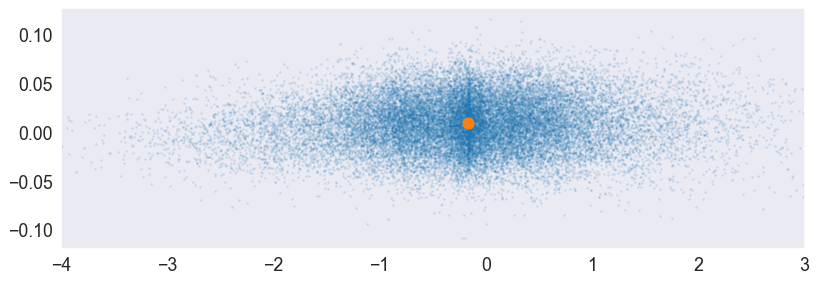

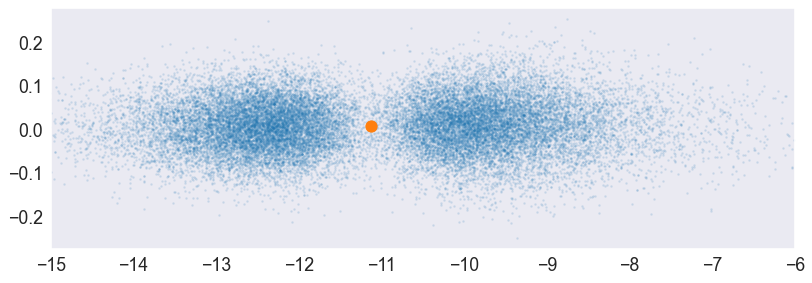

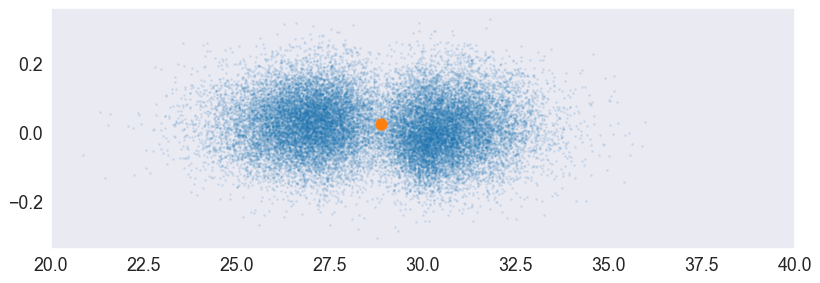

In [7]:
STREAMS={'10_20': None, 
         '30_40': None,
        '50_60': None}

#stream
#%matplotlib notebook
mstream=1
mhalo='1.00e+07'
vhalo=100

k= list(STREAMS.keys())[0]

f= path_data+'/*mass_{}_times_pal5_rgc10*{}*mhalo{}*vhalo{}*.npy'.format(mstream, k.split('_')[0],mhalo, vhalo)
print (f)
filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc*{}*mhalo{}*vhalo{}*.npy'.format(mstream, k.split('_')[0],mhalo, vhalo)))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
prog=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog']
evolved_st= evolve_stream_in_time(st, 0.0001*u.Gyr)
prog_ev=evolve_stream_in_time(prog, 0.0001*u.Gyr)

fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(evolved_st.y, evolved_st.x, s=2, alpha=0.1)
ax.scatter(prog_ev.y[0], prog_ev.x[0], s=100)
ax.set(xlim=[-4, 3])
STREAMS[k]= evolved_st


k= list(STREAMS.keys())[1]

f= path_data+'/*mass_{}_times_pal5_rgc10*{}*mhalo{}*vhalo{}*.npy'.format(mstream, k.split('_')[0],mhalo, vhalo)
print (f)
filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc*{}*mhalo{}*vhalo{}*.npy'.format(mstream, k.split('_')[0],mhalo, vhalo)))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
prog=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog']
evolved_st= evolve_stream_in_time(st, 0.5*u.Gyr)
prog_ev=evolve_stream_in_time(prog, 0.5*u.Gyr)

fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(evolved_st.y, evolved_st.x, s=2, alpha=0.1)
ax.scatter(prog_ev.y[0], prog_ev.x[0], s=100)
ax.set(xlim=[-15, -6])
STREAMS[k]= evolved_st

k= list(STREAMS.keys())[-1]

f= path_data+'/*mass_{}_times_pal5_rgc10*{}*mhalo{}*vhalo{}*.npy'.format(mstream, k.split('_')[0],mhalo, vhalo)
print (f)
filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc*{}*mhalo{}*vhalo{}*.npy'.format(mstream, k.split('_')[0],mhalo, vhalo)))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
prog=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog']
evolved_st= evolve_stream_in_time(st, 0.7*u.Gyr)
prog_ev=evolve_stream_in_time(prog, 0.7*u.Gyr)

fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(evolved_st.y, evolved_st.x, s=2, alpha=0.1)
ax.scatter(prog_ev.y[0], prog_ev.x[0], s=100)
ax.set(xlim=[20, 40])
STREAMS[k]= evolved_st

In [8]:
#gap_center=(16, -41.5)
#gap_center=(0, 50)

In [9]:
#visualize gap in time steps
#for t in np.linspace(0.1, 5, 20):
#    evolved_st= evolve_stream_in_time(st, t*u.Gyr)
#    fig, ax=plt.subplots(figsize=(12, 4))
#    ax.scatter(evolved_st.y, evolved_st.z, s=1, alpha=0.1)
#    ax.set(title='Time {}'.format(t*u.Gyr+200*u.Myr))

8.726646259971647
41.3759801160518
10.471975511965983
49.68027831547767
13.439035240356349
63.68099600010795
13.962634015954642
66.15839831666105
15.707963267948978
74.44319603480756
17.453292519943293
82.80560438702763
34.90658503988659
165.546245707443
43.63323129985823
206.99238728719862
52.359877559829904
248.25069215034367
61.08652381980154
289.6038027388202
69.8131700797732
331.1430359557279
87.26646259971646
413.7440479809731


/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_1571/2950122486.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/gaps_at_distance_mag{}.jpeg'.format(mag_limit), rasterized=True)


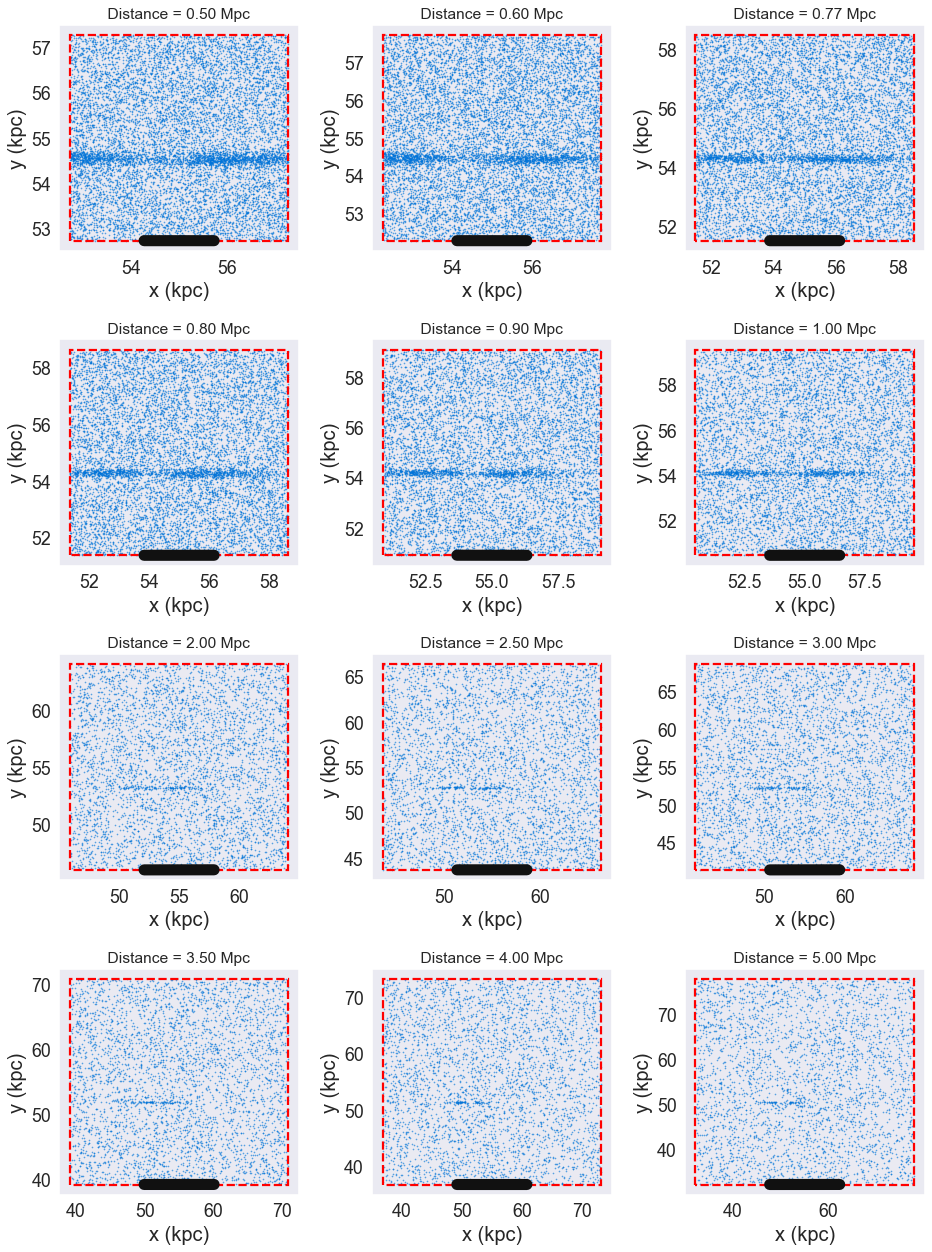

In [16]:
images={}

fig, ax=plt.subplots(figsize=(12, 8*2), ncols=3, nrows=4)

for dmod, a in zip(dmods, np.concatenate(ax)):
    
    #get backgrounds
    
    rgc=np.nanmedian(np.array(dist.split('_')).astype(float))
    
    center=np.array([0, 0 ])+rgc
    
    vals=get_background(center, dist_range=dist, dmod=dmod, FeH_phot=-1., mag_limit=mag_limit)
    
    scaled_arcmin= vals['arcmin']
    
    

    a.plot((center[0]-scaled_arcmin.value/2, center[0]+scaled_arcmin.value/2),
           (vals['data'].x_coord.min(), vals['data'].y_coord.min()), lw=10, c='#111111', linestyle='-')
    

    b=vals['box']
    b.alpha=1.
    b.plot(ax=a)
    
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    a.scatter(vals['data'].x_coord, vals['data'].y_coord, s=0.1, color='#0074D9')
    
    evolved_st= STREAMS[dist]
    
    gap_center=(np.nanmedian( evolved_st.y.value), np.nanmedian(evolved_st.x.value))
    
    rst= resample_stream([evolved_st.y.value, evolved_st.x.value], \
                         28.54, dmod, gap_center, vals['box'].center, vals['box'])
    
    a.scatter(rst[0], rst[1],  s=0.1, color='#0074D9')
    
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Distance = {:.2f} Mpc '.format(  d_M31), fontsize=14)
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)
    

    
    #append values to one image
    images.update({'{:.2f}'.format(dmod): [np.concatenate([vals['data'].x_coord,rst[0]]), \
                                           np.concatenate([vals['data'].y_coord,rst[1]])]})
    

plt.tight_layout()

plt.savefig(path_plot+'/gaps_at_distance_mag{}.jpeg'.format(mag_limit), rasterized=True)

In [11]:
#iimplement a a KL divergence to measure how different the 
from scipy.signal import find_peaks
def kernel_density(x, bw_method=0.01):
    return stats.gaussian_kde(x, bw_method= bw_method)


def return_estimated_2d_kernel(x, y, bw_method=0.1, xmin=0, xmax=0, ymin=0, ymax=0):
    values = np.vstack([x, y])
    k=kernel_density(values, bw_method=bw_method)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid = np.vstack([X.ravel(), Y.ravel()])
    kde=k(grid)
    Z = np.reshape(kde.T, X.shape)
    return { 'grid': grid, 'kde':Z}


def return_estimated_1d_kernel(x,bw_method=0.1, xmin=0, xmax=0):
    k=kernel_density(x, bw_method=bw_method)
    grid = np.linspace(xmin, xmax, 5000)
    kde=k(grid)
    return { 'grid': grid, 'kde':kde, 'estimator': k}

def compute_kl_divergence(p, q):
    return np.nansum(p*np.log(p/q))


def estimate_kl_divergence_iterative(x, bws=[0.1, 0.6], search_region=None):
    
    if search_region is None:
        search_region=[x.min(), x.max()]
    
    #1-d KL divergence iterative
    #alernative: march through the grid of points to see which ones are the closest to 1
    X0=return_estimated_1d_kernel(x,bw_method=bws[0], xmin=search_region[0], xmax=search_region[1])
    X1=return_estimated_1d_kernel(x,bw_method=bws[-1], xmin=search_region[0], xmax=search_region[1])
    
    n_chunks=len(X1['kde'])
    x0=X0['kde']
    x1=X1['kde']
    r=np.exp(-(x0-x1)**2)
    kl_sub_array=[]
    chunks=np.array_split(r, n_chunks)
    
    for chunck in chunks:
        kl_sub_array.append(compute_kl_divergence(chunck, np.ones_like(chunck)))
    return  X1['grid'],  np.array(kl_sub_array)

def estimate_kde_ratios(x, bws=[0.1, 0.6], search_region=None):
    if search_region is None:
        search_region=[x.min(), x.max()]
    
    #1-d KL divergence iterative
    #alernative: march through the grid of points to see which ones are the closest to 1
    X0=return_estimated_1d_kernel(x,bw_method=bws[0], xmin=search_region[0], xmax=search_region[1])
    X1=return_estimated_1d_kernel(x,bw_method=bws[-1], xmin=search_region[0], xmax=search_region[1])
    kderatio=X1['kde']/X0['kde']
    return [X1['grid'], kderatio], [X0['kde'], X1['kde']]


In [12]:
images.keys()

dict_keys(['23.49', '23.89', '24.43', '24.52', '24.77', '25.00', '26.51', '26.99', '27.39', '27.72', '28.01', '28.49'])

In [13]:
peaks_all={}
prominences={}

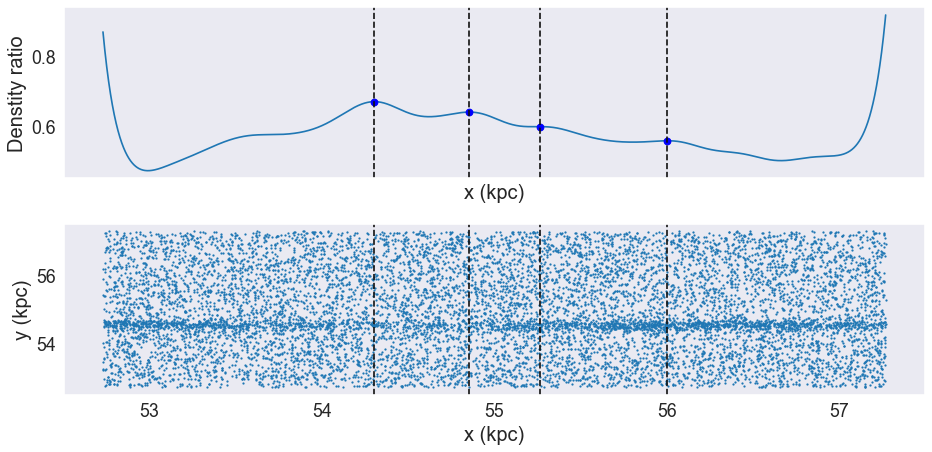

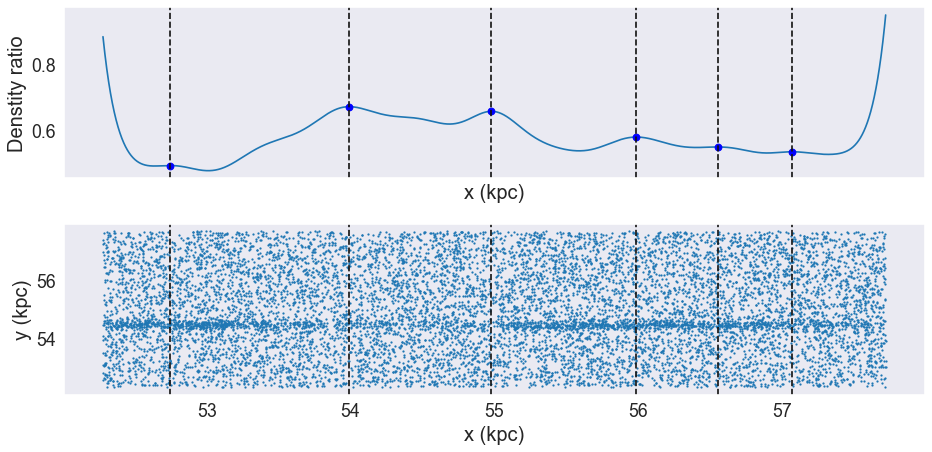

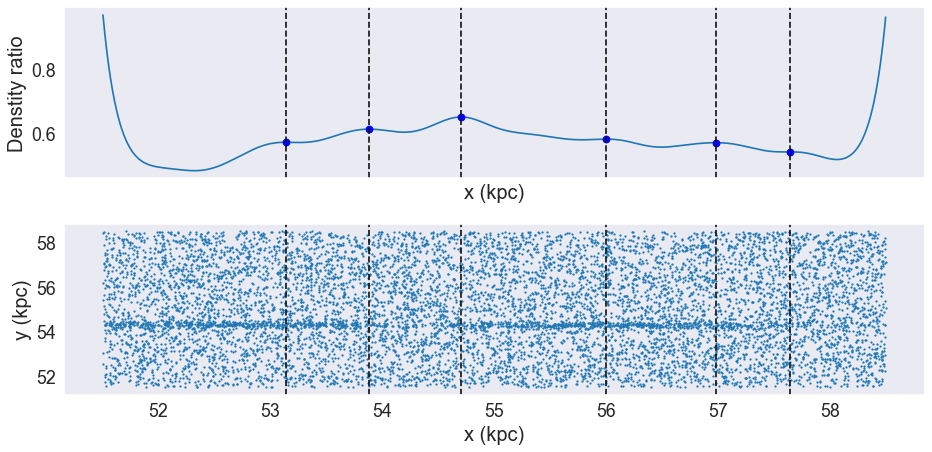

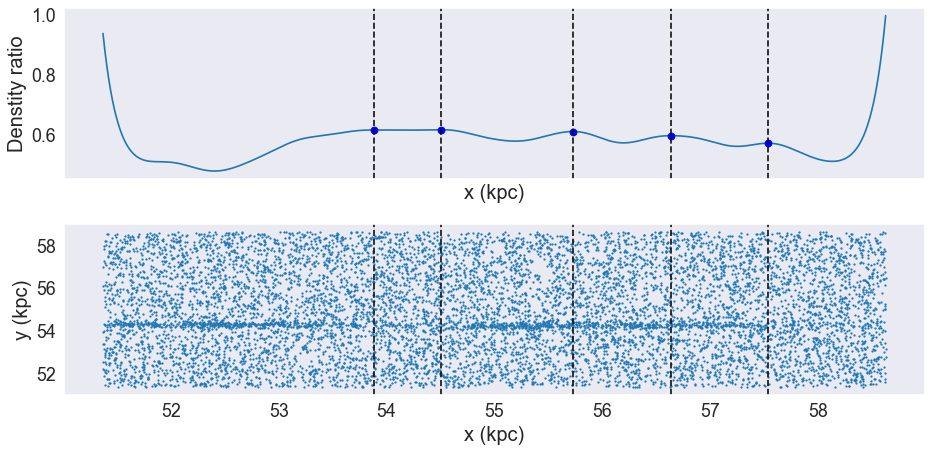

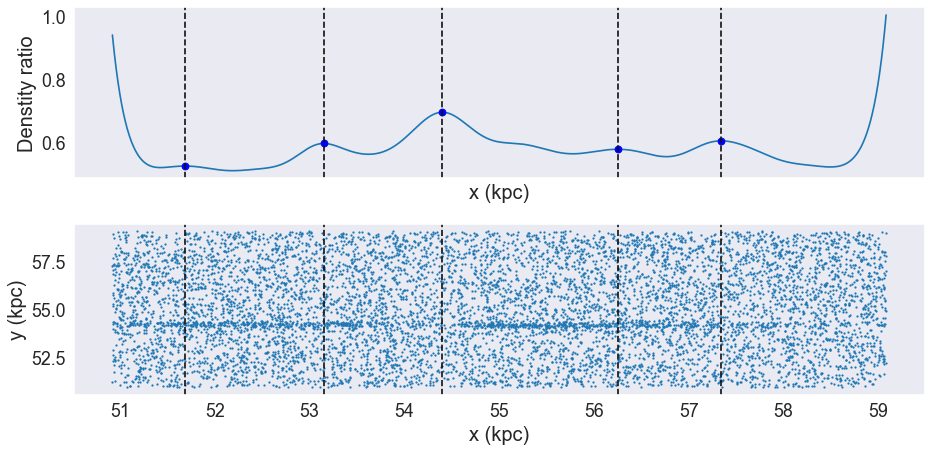

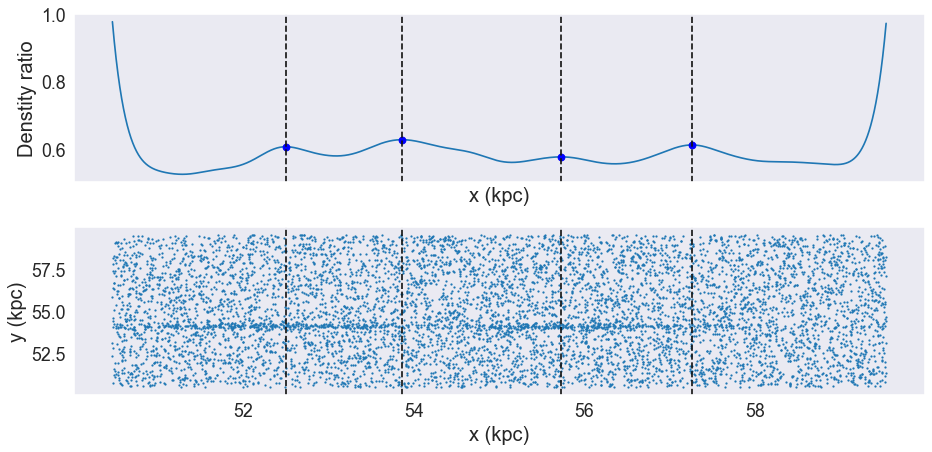

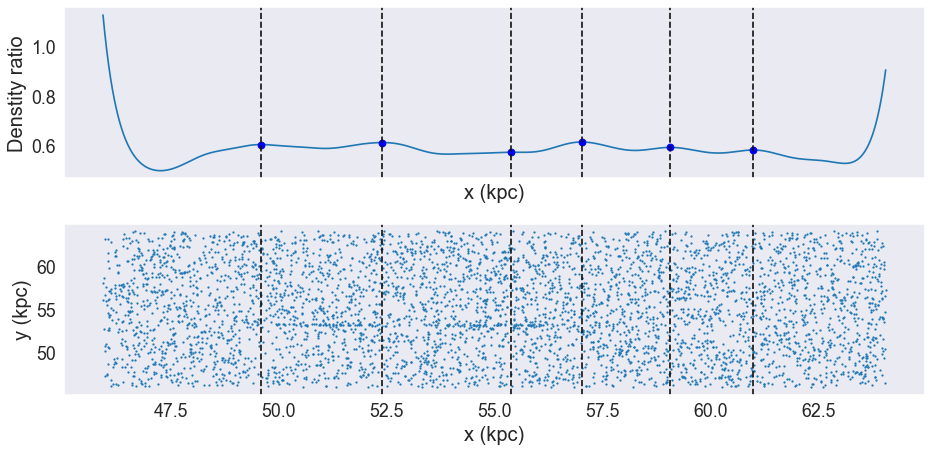

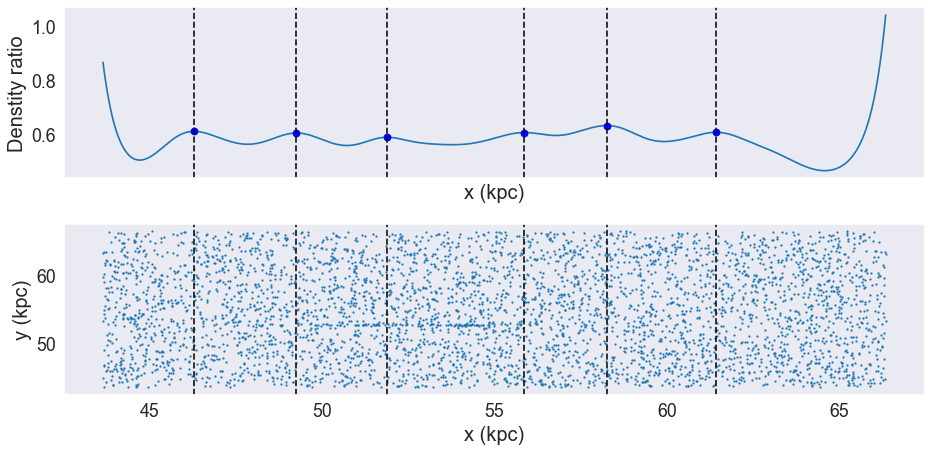

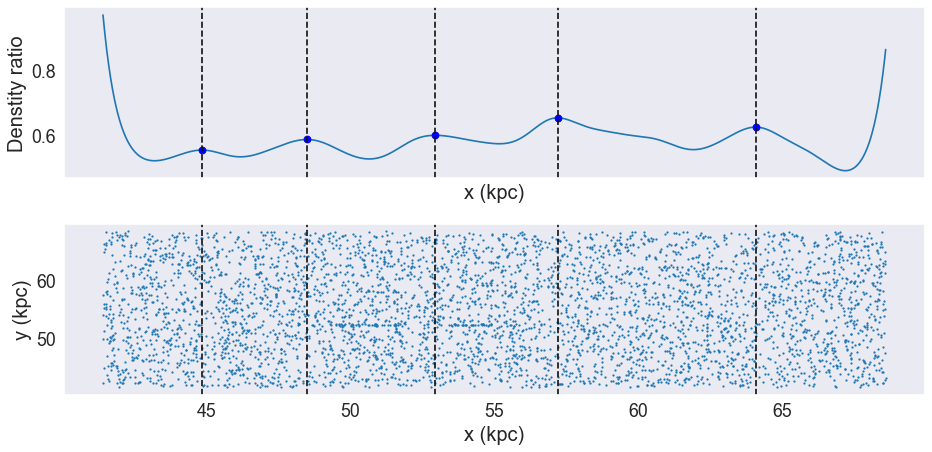

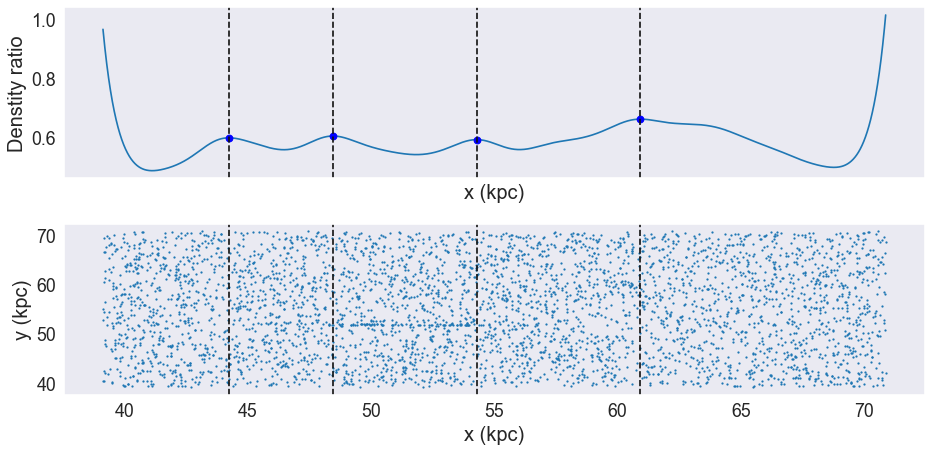

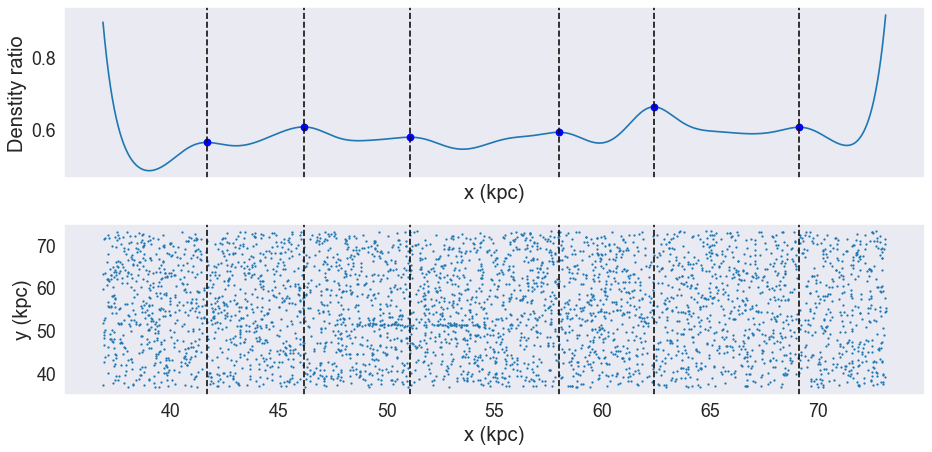

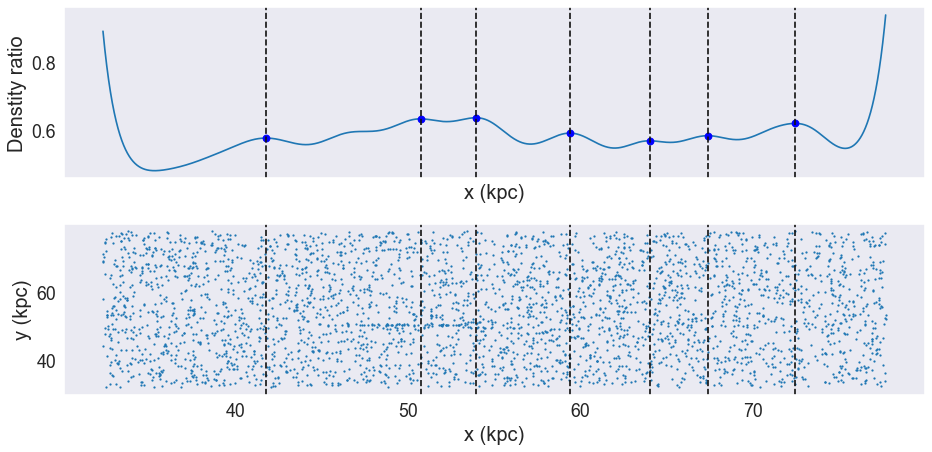

In [14]:
peaks_all={}
prominences={}
#use kde ratios 
for k in images.keys():
    #get the data
    data=images[k]
    #estimate density
    kl, dens=estimate_kde_ratios(data[0], bws=[0.1, 2])
    #find peaks
    peaks, res = find_peaks(kl[-1], prominence=0.0) 
    
    
    peaks_all.update({k: peaks})
    prominences.update({k: res})
    
    fig, (ax, ax1)=plt.subplots(nrows=2, figsize=(12, 6), sharex='col')
    ax.plot(kl[0], kl[1])
    #ax.plot(kl[0], dens[0])
    #ax.plot(kl[0], dens[1])
    #ax.set(yscale='log')
    
    ax.plot( kl[0][peaks], kl[-1][peaks], "ob")

    ax.set(xlabel= 'x (kpc)', ylabel='Denstity ratio')
    for p in  kl[0][peaks]:
        ax1.axvline(p, linestyle='--', color='#111111')
        ax.axvline(p, linestyle='--', color='#111111')

    ax1.scatter(data[0], data[1], s=1)
    ax1.set(xlabel='x (kpc)', ylabel='y (kpc)')
    plt.tight_layout()

[Text(0.5, 0, 'Distance Modulus'), Text(0, 0.5, 'Peak Prominence')]

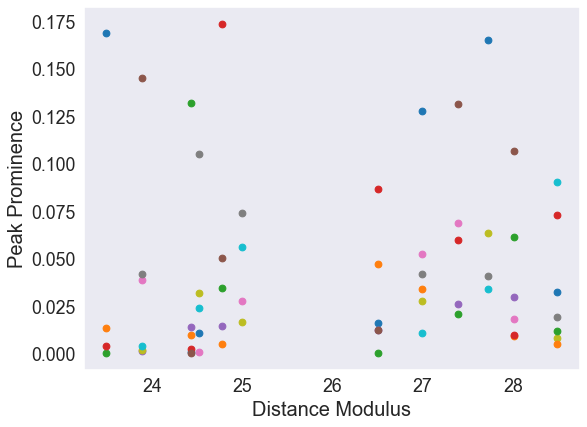

In [15]:
fig, ax=plt.subplots()
for k in prominences.keys():
    peaks=prominences[k]['prominences']
    for p in peaks:
        ax.scatter(float(k), p)
    #ax.errorbar(float(k), np.nanmean(peaks), yerr=np.nanstd(peaks), fmt='o', color='k')

ax.set(xlabel='Distance Modulus', ylabel='Peak Prominence')

In [ ]:
np.rot